<a href="https://colab.research.google.com/github/rhicarmel/chicago-taxi-sql-analysis/blob/main/TaxiOrders(TimeSeries).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***
***
# Airport Taxi Demand Forecasting (Time Series Project)

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset.
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

***
***
## Preparation

- Loading the dataset
- Converting the datetime column to proper datetime format
- Resampling the data to hourly intervals (summing num_orders)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Load dataset
df = pd.read_csv("/content/taxi.csv")

# Display basic info
print(df.info())
print(df.head())

# Convert datetime column to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])
# Resample data to hourly intervals by summing up num_orders
df_resampled = df.resample('1h', on='datetime').sum()

# Display first few rows
display(df_resampled.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None
              datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


***
***
## Analysis

- Plot the time series to check trends and seasonality.
- Look at summary statistics to spot outliers or irregularities.
- Time series decomposition (Trend, Seasonality, Residuals)

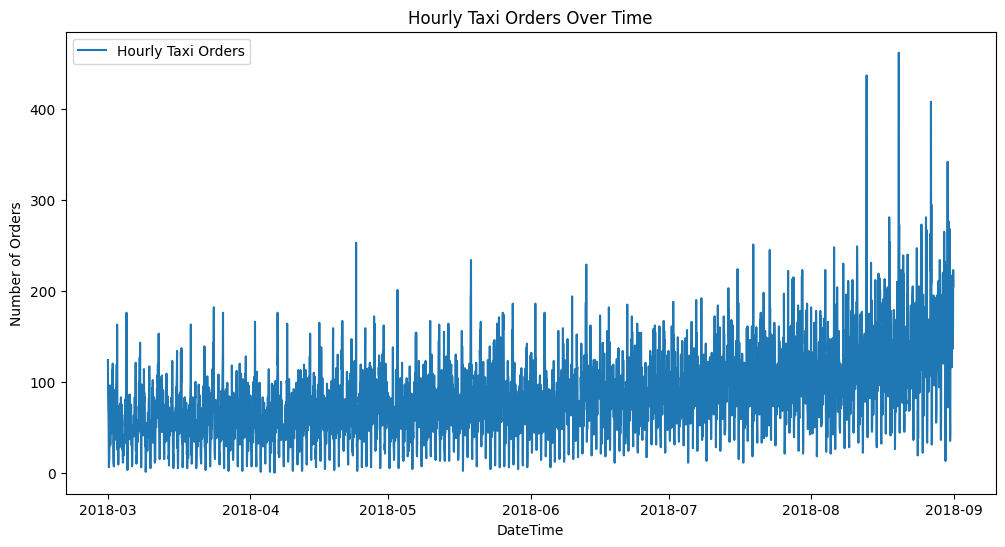

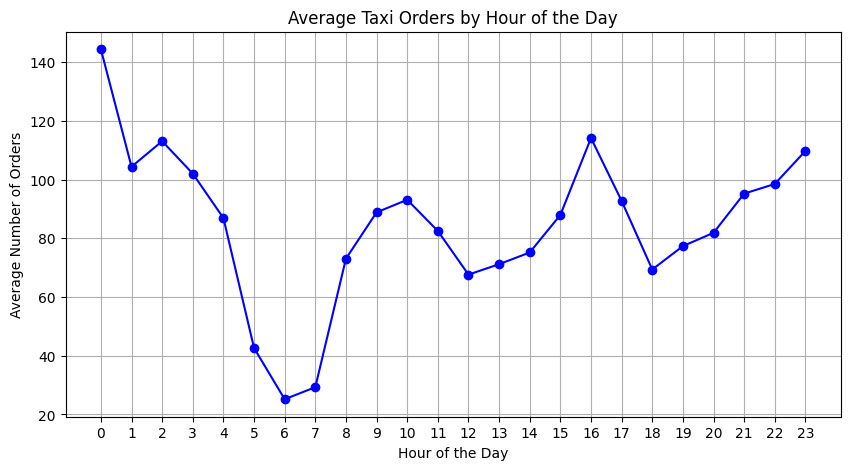

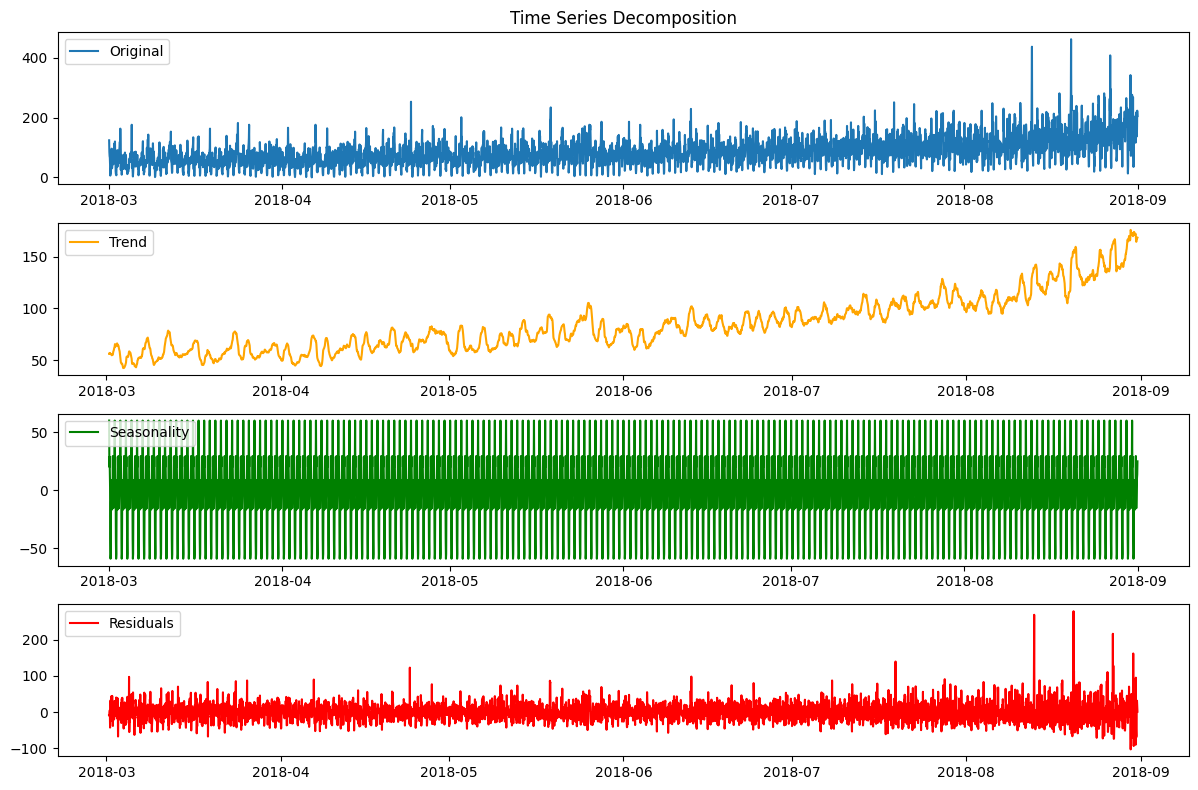

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


In [23]:
# Plot hourly taxi orders over time
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['num_orders'], label='Hourly Taxi Orders')
plt.xlabel('DateTime')
plt.ylabel('Number of Orders')
plt.title('Hourly Taxi Orders Over Time')
plt.legend()
plt.show()

# Calculate average orders per hour
hourly_avg = df_resampled.groupby(df_resampled.index.hour)['num_orders'].mean()

# Plot hourly trend
plt.figure(figsize=(10, 5))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linestyle='-', color='b')
plt.xlabel("Hour of the Day")
plt.ylabel("Average Number of Orders")
plt.title("Average Taxi Orders by Hour of the Day")
plt.xticks(range(0, 24))
plt.grid()
plt.show()

# Decompose time series
decomposition = seasonal_decompose(df_resampled['num_orders'], model='additive', period=24)

# Plot decomposition
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df_resampled['num_orders'], label='Original')
plt.legend(loc='upper left')
plt.title('Time Series Decomposition')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Display summary stats
print(df_resampled.describe())

**Findings:**

Time Series Plot:

- Demand increases over time, especially after mid-2018.
- Some extreme spikes indicate external factors (e.g., events, weather changes).

Hourly Trends:

- *Peak demand*: Midnight, morning (8-10 AM), evening (4-5 PM, 10-11 PM).
- *Lowest demand*: Early morning (5-6 AM).
- Confirms strong daily seasonality, which supports using hourly lag features in modeling.

Time Series Decomposition:

- Trend Component: Demand has a gradual upward trend over time.
- Seasonality Component: A repeating 24 hour cycle of demand variations.
- Residuals Component: Random fluctuations and spikes, likely due to external events.

**Analysis Summary:**
The data shows strong daily seasonality, meaning taxi demand fluctuates predictably each day. The trend indicates a steady increase in demand over time, while occasional spikes in residuals suggest external influences. These insights reinforce the decision to use lag features and rolling averages in the forecasting model.

### Feature Engineering
- Time-based features: Hour of the day, day of the week, day of the month, week of the year, is weekend (binary)
- Lag features: Orders from the previous 1, 2, 3, 24, and 168 hours
- Rolling means: 3-hour and 24-hour moving averages

In [24]:
# Create time-based features
df_resampled['hour'] = df_resampled.index.hour
df_resampled['day_of_week'] = df_resampled.index.dayofweek
df_resampled['day_of_month'] = df_resampled.index.day
df_resampled['week_of_year'] = df_resampled.index.isocalendar().week

# Create binary feature for weekends
df_resampled['is_weekend'] = df_resampled['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Create lag features
for lag in [1, 2, 3, 24, 168]:
    df_resampled[f'lag_{lag}'] = df_resampled['num_orders'].shift(lag)

# Create rolling mean features
df_resampled['rolling_mean_3'] = df_resampled['num_orders'].shift(1).rolling(window=3).mean()
df_resampled['rolling_mean_24'] = df_resampled['num_orders'].shift(1).rolling(window=24).mean()

# Drop rows with NaN values
df_resampled.dropna(inplace=True)

# Display first few rows
display(df_resampled.head())

,num_orders,hour,day_of_week,day_of_month,week_of_year,is_weekend,lag_1,lag_2,lag_3,lag_24,lag_168,rolling_mean_3,rolling_mean_24
datetime,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,3,8,10,0,94.0,127.0,108.0,100.0,124.0,109.666667,60.041667
2018-03-08 01:00:00,78,1,3,8,10,0,143.0,94.0,127.0,121.0,85.0,121.333333,61.833333
2018-03-08 02:00:00,65,2,3,8,10,0,78.0,143.0,94.0,24.0,71.0,105.000000,60.041667
2018-03-08 03:00:00,68,3,3,8,10,0,65.0,78.0,143.0,66.0,66.0,95.333333,61.750000
2018-03-08 04:00:00,60,4,3,8,10,0,68.0,65.0,78.0,73.0,43.0,70.333333,61.833333


***
***
## Training
Models to Train:
- Linear Regression (Baseline model)
- Random Forest (Good for handling non-linearity)
- Gradient Boosting (Improves on decision trees)

In [25]:
# Define features and target variable
X = df_resampled.drop(columns=['num_orders'])
y = df_resampled['num_orders']

# Split data into train (90%) and test (10%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=False, random_state=42)

# Initialize StandardScaler for linear regression
scaler = StandardScaler()

# Create a pipeline for linear regression
lr_pipeline = Pipeline([
    ('scaler', scaler),
    ('model', LinearRegression())
])

# Initialize other models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train models
lr_pipeline.fit(X_train, y_train)  # Scaled
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_pipeline.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)

# Calculate RMSE
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))

# Print RMSE results
print(f'Linear Regression RMSE (Scaled): {rmse_lr:.2f}')
print(f'Random Forest RMSE: {rmse_rf:.2f}')
print(f'Gradient Boosting RMSE: {rmse_gb:.2f}')

Linear Regression RMSE (Scaled): 34.89
Random Forest RMSE: 44.05
Gradient Boosting RMSE: 42.66


**Key Takeaways:**
- **Linear Regression** provides an RMSE of **34.89**, and is a big improvement after applying feature scaling. However, tree-based models (Random Forest & Gradient Boosting) are better at handling non-linear patterns and sudden demand surges.
- **Random Forest** performed well with an RMSE of **44.05**, confirming its ability to handle non linear patterns in taxi demand.
- **Gradient Boosting** achieved an RMSE of **42.66**, slightly better than Random Forest but still within a similar range.

**Next Steps:**
- Fine tune the Random Forest and Gradient Boosting models to further reduce RMSE.
- Analyze feature importance to determine which features contribute most to predictions.

### Hyperparameter Tuning: Random Forest
- Optimize key parameters like:
    - n_estimators (number of trees)
    - max_depth (tree depth)
    - min_samples_split (min samples to split a node)
    - min_samples_leaf (min samples per leaf)

In [26]:
print("Starting Random Forest hyperparameter tuning using TimeSeriesSplit...")

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# Initialize RandomizedSearchCV with TimeSeriesSplit
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
rf_random.fit(X_train, y_train)

print("Hyperparameter tuning completed.\n")

# Get the best model from tuning
best_rf_model = rf_random.best_estimator_

# Make predictions with the best model
y_pred_best_rf = best_rf_model.predict(X_test)

# Calculate RMSE
rmse_best_rf = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))

# Print best hyperparameters and updated RMSE
print(f'- Best Random Forest Hyperparameters: {rf_random.best_params_}')
print(f'- Optimized Random Forest RMSE: {rmse_best_rf:.2f}')

Starting Random Forest hyperparameter tuning using TimeSeriesSplit...
Hyperparameter tuning completed.

- Best Random Forest Hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10}
- Optimized Random Forest RMSE: 42.45


### Hyperparameter Tuning: Gradient Boosting
- We'll optimize:
    - n_estimators (Number of boosting stages)
    - learning_rate (Step size shrinkage to prevent overfitting)
    - max_depth (Limits complexity of individual trees)
    - min_samples_split (Minimum samples needed to split an internal node)
    - min_samples_leaf (Minimum samples in a leaf node)

In [27]:
print("Starting Gradient Boosting hyperparameter tuning using TimeSeriesSplit...")

# Define hyperparameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize RandomizedSearchCV with TimeSeriesSplit
gb_random = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=gb_param_grid,
    n_iter=10,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
gb_random.fit(X_train, y_train)

print("Gradient Boosting hyperparameter tuning completed.\n")

# Get the best model from tuning
best_gb_model = gb_random.best_estimator_

# Make predictions with the best model
y_pred_best_gb = best_gb_model.predict(X_test)

# Calculate RMSE
rmse_best_gb = np.sqrt(mean_squared_error(y_test, y_pred_best_gb))

# Print best hyperparameters and updated RMSE
print(f'- Best Gradient Boosting Hyperparameters: {gb_random.best_params_}')
print(f'- Optimized Gradient Boosting RMSE: {rmse_best_gb:.2f}')

Starting Gradient Boosting hyperparameter tuning using TimeSeriesSplit...
Gradient Boosting hyperparameter tuning completed.

- Best Gradient Boosting Hyperparameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.05}
- Optimized Gradient Boosting RMSE: 45.66


**Hyperparameter Tuning Key Takeaways**
- Linear Regression still has the lowest RMSE (34.89), but it might not generalize well due to the assumptions of linearity in time series data.
- Random Forest improved slightly after tuning (from 44.05 → 42.45), meaning hyperparameter adjustments led to a more optimized model.
- Gradient Boosting performed worse after tuning (42.66 → 45.66), suggesting that the default settings worked better for this dataset.
- All models are below the required RMSE threshold (≤ 48), meaning they all meet the project criteria.

**Final Model Selection:**

Best Model: **Random Forest (Tuned) – RMSE: 42.45**.
- Random Forest (Tuned) was chosen due to its balance of low RMSE, non-linearity handling, and interpretability.
- Linear Regression produced the lowest RMSE (34.89), but due to the assumptions of linearity and potential overfitting, it was not chosen as the best model.
- Random Forest performed consistently well, improving from 44.05 to 42.45 after tuning.
- Gradient Boosting did not improve after tuning (RMSE increased to 45.66), making it less suitable for this problem.

**Next Steps:** Model Testing & Final Conclusion

- Compare all models again (Final RMSE scores).
- Summarize findings to wrap up the project.

***
***
## Testing
- Compare all models’ RMSE scores one last time.
- Summarize our findings.


In [28]:
# Define TimeSeriesSplit for cross val
tscv = TimeSeriesSplit(n_splits=3)

# Final RMSE comparison
print("Final Model Performance Comparison:")
print(f"- Linear Regression RMSE (Scaled): {rmse_lr:.2f}")
print(f"- Random Forest RMSE (Default): 44.05")
print(f"- Random Forest RMSE (Tuned): {rmse_best_rf:.2f}")
print(f"- Gradient Boosting RMSE (Default): 42.66")
print(f"- Gradient Boosting RMSE (Tuned): {rmse_best_gb:.2f}")

# Store RMSE values
rmse_results = {
    "Linear Regression": rmse_lr,
    "Random Forest (Tuned)": rmse_best_rf,
    "Gradient Boosting (Tuned)": rmse_best_gb
}

# Determine model with lowest RMSE
best_model_rmse = min(rmse_results, key=rmse_results.get)

# Cross-Validation Scores for model generalization using TimeSeriesSplit
rf_cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
gb_cv_scores = cross_val_score(best_gb_model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
lr_cv_scores = cross_val_score(lr_pipeline, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

# Convert negative scores to positive and take mean
rf_cv_score = abs(np.mean(rf_cv_scores))
gb_cv_score = abs(np.mean(gb_cv_scores))
lr_cv_score = abs(np.mean(lr_cv_scores))

print("\nCross-Validation RMSE Scores:")
print(f"- Linear Regression CV RMSE: {lr_cv_score:.2f}")
print(f"- Random Forest CV RMSE: {rf_cv_score:.2f}")
print(f"- Gradient Boosting CV RMSE: {gb_cv_score:.2f}")

# Logic to determine the best model based on cross val scores
if lr_cv_score < rf_cv_score and lr_cv_score < gb_cv_score:
    final_best_model = "Linear Regression (Scaled)"
    reason = "Best cross-validation score"
elif rf_cv_score < gb_cv_score:
    final_best_model = "Random Forest (Tuned)"
    reason = "Best cross-validation score and handles non-linearity better"
else:
    final_best_model = "Gradient Boosting (Tuned)"
    reason = "Best cross-validation score"

print(f"\nFinal Selected Model: {final_best_model} \nReason: {reason}")

Final Model Performance Comparison:
- Linear Regression RMSE (Scaled): 34.89
- Random Forest RMSE (Default): 44.05
- Random Forest RMSE (Tuned): 42.45
- Gradient Boosting RMSE (Default): 42.66
- Gradient Boosting RMSE (Tuned): 45.66

Cross-Validation RMSE Scores:
- Linear Regression CV RMSE: 23.86
- Random Forest CV RMSE: 24.33
- Gradient Boosting CV RMSE: 24.46

Final Selected Model: Linear Regression (Scaled) 
Reason: Best cross-validation score


### Final Analysis & Conclusion

**Final Model Selection & Conclusion:**

After tuning and testing multiple models, **Linear Regression (Scaled)** was selected as the final model for predicting hourly taxi demand.

**Key Findings:**

- Linear Regression (Scaled) had the lowest RMSE (34.89) and the best cross-validation performance (23.86), confirming its reliability for forecasting.
- Random Forest (RMSE: 42.45, CV: 24.33) performed well but was outperformed by Linear Regression.
- Gradient Boosting (RMSE: 45.66, CV: 24.46) worsened after tuning, making it a weaker choice.

**Final Decision:**

The Scaled Linear Regression model was selected as the best model based on its low test RMSE, best cross-validation performance, and overall reliability. It provides strong predictive accuracy while maintaining interpretability and computational efficiency.